In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.nn as nn

import sys, os
from tqdm import tqdm
from skimage.transform import resize
import cv2
from PIL import Image
from numpy import asarray

### Creating the model

In [2]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-kmj2v7g6
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-kmj2v7g6
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368688 sha256=851550834f5bec8f2ef6c53083655648eaf330ad6919279df68e998ce3db4e5d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5czedyvl/wheels/79/51/d7/69f91d37121befe21d9c52332e04f592e17d1cabc7319b3e09
  Created wheel for ftfy: filename=ftfy-5.9-cp37-none-any.whl size=46451 sha256=649ffadd0dcab6369578e5f15d3592b1fb3fc2fa2d3d0245e3260bca968b1ea8
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built clip ftfy


In [3]:
import clip
from tqdm.notebook import tqdm

print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'ViT-B/32']


In [4]:
model, preprocess = clip.load("RN50")

100%|████████████████████████████████████████| 256M/256M [00:01<00:00, 132MiB/s]


In [5]:
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [6]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

### Downloading the dataset

In [7]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

In [8]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
device

'cuda'

In [11]:
def get_similar(images, indices):
  ret_imgs = []
  for i, value in enumerate(indices):
    ret_imgs.append(images[value])
  return ret_imgs

In [12]:
def calculate_distances(target, targetID, conv_features, nbr = 5):
  distances = []
  for i, img_conv in enumerate(conv_features):
    distance = np.linalg.norm(target.cpu().detach().numpy() - img_conv)
    if i != targetID: 
      distances.append(distance)

  indices = np.argsort(distances)[:nbr]
  return distances, indices

In [13]:
def generate_samples(dataset, nbr = 5):
  random_imgs = np.random.randint(0, 500, nbr)
  samples = []

  for i in random_imgs:
    samples.append(dataset[i][0].unsqueeze(0))
  return samples, random_imgs

### Regional Max-Pooling

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [16]:
try:
  !rm Brueghel.zip?dl=0
except:
  print("Does not exist")

In [17]:
!wget 'https://www.dropbox.com/s/nljxhtct5d7285h/Brueghel.zip?dl=0'
!unzip Brueghel.zip?dl=0

--2021-03-08 17:07:18--  https://www.dropbox.com/s/nljxhtct5d7285h/Brueghel.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nljxhtct5d7285h/Brueghel.zip [following]
--2021-03-08 17:07:18--  https://www.dropbox.com/s/raw/nljxhtct5d7285h/Brueghel.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc65d6c75cf22075195c1b84f2c0.dl.dropboxusercontent.com/cd/0/inline/BKSRBQ4_fo2v1l7SkKO8aqRJsm5oGyvynalcRP5yLK1TL99hJtjc6_ZkZ4NQwR4k_xttLSboIMIXsyAtMnGx0jTLkHTRr6MbpXnm6wt3Q7JBApuGlvT8X9DAwCSOFVWBjXI/file# [following]
--2021-03-08 17:07:19--  https://uc65d6c75cf22075195c1b84f2c0.dl.dropboxusercontent.com/cd/0/inline/BKSRBQ4_fo2v1l7SkKO8aqRJsm5oGyvynalcRP5yLK1TL99hJtjc6_ZkZ4NQwR4k_xttLSboIMIXsyAtMnGx0jTLkHTRr6MbpXnm6wt3Q7

In [18]:
!mv  Brueghel train
!mkdir Brueghel
!mv train Brueghel
!cd Brueghel

In [19]:
from torchvision import datasets, transforms, models

input_resolution = 800
transformation = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/Brueghel/", transform=transformation)

In [20]:
dsets

Dataset ImageFolder
    Number of datapoints: 3174
    Root location: /content/gdrive/My Drive/Brueghel/
    StandardTransform
Transform: Compose(
               Resize(size=800, interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(800, 800))
               ToTensor()
           )

In [21]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=16, shuffle=False, num_workers=6)

In [22]:
import math
import torch.nn.functional as F

def rmac(x, L=5, eps=1e-6):
    ovr = 0.4 # desired overlap of neighboring regions
    steps = torch.Tensor([2, 3, 4, 5, 6, 7]) # possible regions for the long dimension

    W = x.size(3)
    H = x.size(2)

    w = min(W, H)
    w2 = math.floor(w/2.0 - 1)

    b = (max(H, W)-w)/(steps-1)
    (tmp, idx) = torch.min(torch.abs(((w**2 - w*b)/w**2)-ovr), 0) # steps(idx) regions for long dimension

    # region overplus per dimension
    Wd = 0;
    Hd = 0;
    if H < W:  
        Wd = idx.item() + 1
    elif H > W:
        Hd = idx.item() + 1

    v = F.max_pool2d(x, (x.size(-2), x.size(-1)))
    v = v / (torch.norm(v, p=2, dim=1, keepdim=True) + eps).expand_as(v)

    for l in range(1, L+1):
        wl = math.floor(2*w/(l+1))
        wl2 = math.floor(wl/2 - 1)

        if l+Wd == 1:
            b = 0
        else:
            b = (W-wl)/(l+Wd-1)
        cenW = torch.floor(wl2 + torch.Tensor(range(l-1+Wd+1))*b) - wl2 # center coordinates
        if l+Hd == 1:
            b = 0
        else:
            b = (H-wl)/(l+Hd-1)
        cenH = torch.floor(wl2 + torch.Tensor(range(l-1+Hd+1))*b) - wl2 # center coordinates
            
        for i_ in cenH.tolist():
            for j_ in cenW.tolist():
                if wl == 0:
                    continue
                R = x[:,:,(int(i_)+torch.Tensor(range(wl)).long()).tolist(),:]
                R = R[:,:,:,(int(j_)+torch.Tensor(range(wl)).long()).tolist()]
                vt = F.max_pool2d(R, (R.size(-2), R.size(-1)))
                vt = vt / (torch.norm(vt, p=2, dim=1, keepdim=True) + eps).expand_as(vt)
                v += vt

    return v

In [23]:
# Removing the last layers of resnet50
net_conv = torch.nn.Sequential(*(list(model.visual.children())[:-7]))
print(net_conv)

# do not forget:
net_conv = net_conv.eval()

#Giving the weights of initial CLIP Transformer to the convolution network
with torch.no_grad():
    net_conv[0].weight = torch.nn.Parameter(model.visual.conv1.weight.type(torch.FloatTensor))
    net_conv[1].weight = torch.nn.Parameter(model.visual.bn1.weight.type(torch.FloatTensor))
    net_conv[2].weight = torch.nn.Parameter(model.visual.conv2.weight.type(torch.FloatTensor))
    net_conv[3].weight = torch.nn.Parameter(model.visual.bn2.weight.type(torch.FloatTensor))
    net_conv[4].weight = torch.nn.Parameter(model.visual.conv3.weight.type(torch.FloatTensor))
    net_conv[5].weight = torch.nn.Parameter(model.visual.bn3.weight.type(torch.FloatTensor))

Sequential(
  (0): RecursiveScriptModule(original_name=Conv2d)
  (1): RecursiveScriptModule(original_name=BatchNorm2d)
  (2): RecursiveScriptModule(original_name=Conv2d)
  (3): RecursiveScriptModule(original_name=BatchNorm2d)
  (4): RecursiveScriptModule(original_name=Conv2d)
  (5): RecursiveScriptModule(original_name=BatchNorm2d)
)


In [24]:
vision_width = model.visual.conv1.weight.shape[0]
vision_patch_size = model.visual.conv1.weight.shape[-1]

grid_size = 7
image_resolution = vision_patch_size * grid_size
vision_heads = vision_width // 64

print("vision_width", vision_width)
print("vision_patch_size", vision_patch_size)
print("grid_size", grid_size)
print("image_resolution", image_resolution)
print("vision_heads", vision_heads)

vision_width 32
vision_patch_size 3
grid_size 7
image_resolution 21
vision_heads 0


In [25]:
image, label = dsets[0]
print("Images shape: ", image.shape)

Images shape:  torch.Size([3, 800, 800])


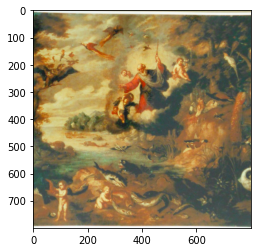

In [26]:
plt.imshow(image.permute(1, 2, 0).detach().numpy())

In [27]:
conv = net_conv.eval().to(device)
image = image.unsqueeze(0)
print(image.shape)
target_img = conv(image.to(device))
print("target_img before RMAC: ", target_img.shape)
output = torch.nn.functional.normalize(target_img, p=2.0, dim=1)
target_img = rmac(output)
target_img = torch.nn.functional.normalize(target_img, p=2.0, dim=1)
target_img.shape

torch.Size([1, 3, 800, 800])
target_img before RMAC:  torch.Size([1, 64, 400, 400])


torch.Size([1, 64, 1, 1])

In [26]:
def preconvfeat(dataloader):
    conv_features = [] 
    imgs = []
    for data in dataloader:
        input, label = data
        with torch.no_grad():
          for i in range(input.shape[0]):
            img = input[i].to(device)
            img = img.unsqueeze(0)
            x = conv(img)
            output = torch.nn.functional.normalize(x, p=2.0, dim=1)
            x = rmac(output)
            x = torch.nn.functional.normalize(x, p=2.0, dim=1)
            imgs.append(img)
            conv_features.append(x.cpu().detach().numpy())
    
    return conv_features, imgs

In [29]:
conv = conv.to(device)
features, images = preconvfeat(data_loader)

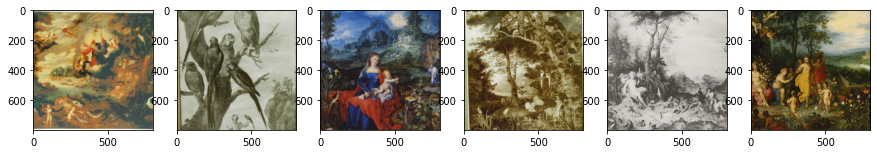

In [30]:
dist, indices = calculate_distances(target_img, 0, features)

ret_imgs = get_similar(images, indices)
fix, ax = plt.subplots(1, 6, figsize=(15, 10))

ax[0].imshow(image[0].permute(1, 2, 0).detach().numpy())
for i in range(0, 5):
  ax[i+1].imshow(ret_imgs[i][0].permute(1, 2, 0).cpu().detach().numpy())


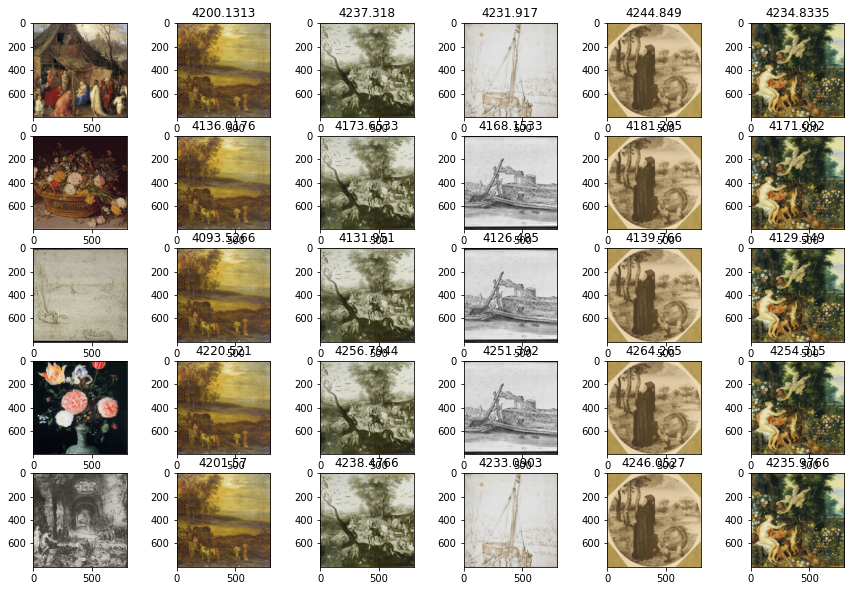

In [31]:
samples, ind = generate_samples(dsets, 5)
fix, ax = plt.subplots(5, 6, figsize=(15, 10))
conv = conv.cpu()
for i in range(0, 5):
  ax[i][0].imshow(samples[i][0].permute(1, 2, 0).cpu().detach().numpy())
  target_img = conv(samples[i])
  targetID = ind[i]
  dist, indices = calculate_distances(target_img, targetID, features)
  ret_imgs = get_similar(images, indices)
  for j in range(0, 5):
    ax[i][j+1].set_title(dist[j])
    ax[i][j+1].imshow(ret_imgs[j][0].permute(1, 2, 0).cpu().detach().numpy())

### Re-adjust the feature extractor network

In [23]:
# Removing the last layers of resnet50
net_conv = torch.nn.Sequential(*(list(model.visual.children())[:-7]))
print(net_conv)

# do not forget:
net_conv = net_conv.eval()

#Giving the weights of initial CLIP Transformer to the convolution network
with torch.no_grad():
    net_conv[0].weight = torch.nn.Parameter(model.visual.conv1.weight.type(torch.FloatTensor))
    net_conv[1].weight = torch.nn.Parameter(model.visual.bn1.weight.type(torch.FloatTensor))
    net_conv[2].weight = torch.nn.Parameter(model.visual.conv2.weight.type(torch.FloatTensor))
    net_conv[3].weight = torch.nn.Parameter(model.visual.bn2.weight.type(torch.FloatTensor))
    net_conv[4].weight = torch.nn.Parameter(model.visual.conv3.weight.type(torch.FloatTensor))
    net_conv[5].weight = torch.nn.Parameter(model.visual.bn3.weight.type(torch.FloatTensor))

Sequential(
  (0): RecursiveScriptModule(original_name=Conv2d)
  (1): RecursiveScriptModule(original_name=BatchNorm2d)
  (2): RecursiveScriptModule(original_name=Conv2d)
  (3): RecursiveScriptModule(original_name=BatchNorm2d)
  (4): RecursiveScriptModule(original_name=Conv2d)
  (5): RecursiveScriptModule(original_name=BatchNorm2d)
)


In [29]:
conv = net_conv.eval().to(device)

image, label = dsets[0]
print("Images shape: ", image.shape)
image = image.unsqueeze(0)
print(image.shape)
target_img = conv(image.to(device))
print("target_img before RMAC: ", target_img.shape)
## Normalzie and apply RMAC
output = torch.nn.functional.normalize(target_img, p=2.0, dim=1)
target_img = rmac(output, L=8)
target_img = torch.nn.functional.normalize(target_img, p=2.0, dim=1)

target_img.shape

Images shape:  torch.Size([3, 800, 800])
torch.Size([1, 3, 800, 800])
target_img before RMAC:  torch.Size([1, 64, 400, 400])


torch.Size([1, 64, 1, 1])

In [32]:
def preconvfeat(dataloader):
    conv_features = [] 
    imgs = []
    for data in dataloader:
        input, label = data
        with torch.no_grad():
          for i in range(input.shape[0]):
            img = input[i].to(device)
            img = img.unsqueeze(0)
            x = conv(img)
            x = torch.nn.functional.normalize(x, p=2.0, dim=1)
            x = rmac(x, L = 8)
            x = torch.nn.functional.normalize(x, p=2.0, dim=1)
            imgs.append(img)
            conv_features.append(x.cpu().detach().numpy())
    
    return conv_features, imgs

In [ ]:
conv = conv.to(device)
features, images = preconvfeat(data_loader)

In [ ]:
dist, indices = calculate_distances(target_img, 0, features)

ret_imgs = get_similar(images, indices)
fix, ax = plt.subplots(1, 6, figsize=(15, 10))

ax[0].imshow(image[0].permute(1, 2, 0).detach().numpy())
for i in range(0, 5):
  ax[i+1].imshow(ret_imgs[i][0].permute(1, 2, 0).cpu().detach().numpy())